# GEOG696C Spatiotemporal Data Analytics: Term Project
## plotNLP.ipynb
This script plots the NLP time series of media flood reports against the precip and inundation data, as well as other time series as additional validation (Twitter reports, EM-DAT).

In [207]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import math
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import rasterio.warp
from rasterio.crs import CRS
from shapely.geometry import box
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray as rx
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import scipy as sp
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import matplotlib.ticker as ticker

In [2]:
# Set the root path
# rootPath = Path('/media/mule/Projects/NASA/NIP/Data')
rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/01_study/2023/geog696c/project/data')

In [3]:
font_dirs = ['C:/users/alexsaunders/appdata/local/microsoft/windows/fonts']
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Work Sans'

## 1) Load the NLP data on the count of media reports

In [4]:
nlp=pd.read_csv('C:/Users/alexsaunders/Documents/01_uoa/04_git/dissertation/data/nlp/processed/ArticlesByDayByDivision.csv', index_col=0)#, keep_default_na=False)
nlp.index = pd.to_datetime(nlp.index)
nlp=nlp.iloc[:, :-5]
# nlp[nlp=='']=np.nan

### Create xarray and resample to monthly

In [5]:
divs=list(nlp.columns.str.capitalize())
times=list(nlp.index)

In [6]:
# Convert to xarray data array
nlpxr = xr.DataArray(
    nlp,
    coords={'time': times, 'division': divs},
    dims=['time', 'division']
)

In [7]:
# Set nans to zero since we want to use all data - maybe not the best assumption?
# nlpxr = nlpxr.fillna(0)

In [12]:
nlpMonthlyCount = nlpxr.sel(division='All').resample(time='1M', skipna=True).sum(dim='time')

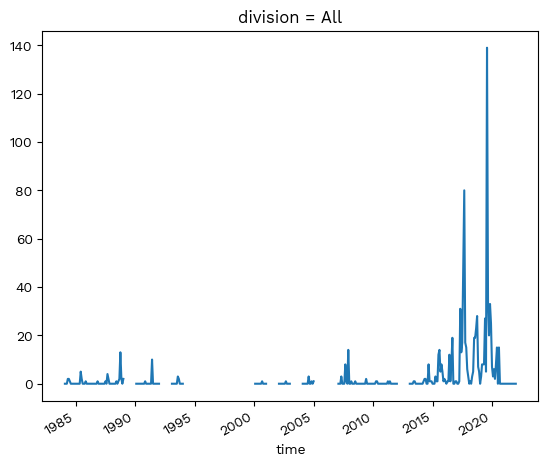

In [13]:
nlpMonthlyCount.plot()

## 2) Load the precip and FIA data

In [14]:
chirpsPath=rootPath/'chirps'
rawPath=chirpsPath/'raw'
precip = xr.open_dataarray(chirpsPath/'xr/precip.nc')
# precip

In [15]:
FIAPath = rootPath/'pixelFIA/xr/'
FIA = xr.open_dataarray(FIAPath/'pixelFIACountryCoarse.nc')
FIA = FIA.where(FIA!=-9999, np.nan)
# FIA

## 3) Resample precip and FIA to monthly total

In [16]:
precipMonthlySum = precip.resample(time='1M', skipna=True).sum(dim='time')
precipMonthlyTotal = precipMonthlySum.sum(dim=["lat", "lon"])

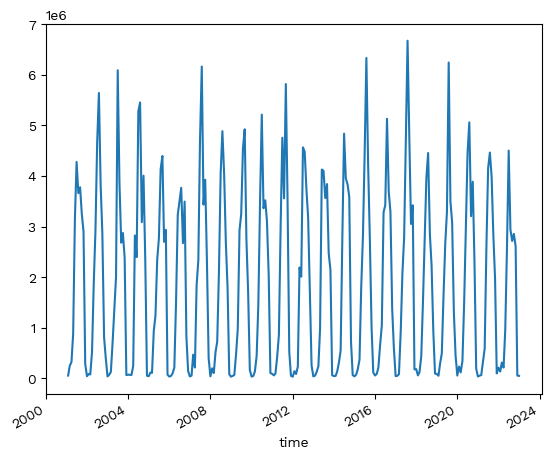

In [17]:
precipMonthlyTotal.plot()

### Get area of pixels for comoputing total flooded area

In [25]:
dataPath = Path('Z:/media/mule/Projects/NASA/NIP/Data/Models/DeepLearning/Inference/CrossValidation/FullRaster/Ensemble')
dataFiles = [file for file in list(dataPath.iterdir()) if file.suffix=='.tiff']
file = dataFiles[0]
dst_crs='epsg:32646'
outFile = 'rasterReproj.tif'
outPath=rootPath/'raster'
outPath.mkdir(exist_ok=True)

In [28]:
with rio.open(file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(outPath/outFile, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [41]:
# Open reprojected raster and get pixel area
raster=rio.open(outPath/outFile)
gt=raster.transform
pixelSizeX = gt[0]
pixelSizeY =-gt[4]
# Area of each pixel in m
pixelArea=pixelSizeX*pixelSizeY
print('Area of each pixel in m',pixelArea)
rasterAr=raster.read(1)
nPixels=rasterAr.shape[0]*rasterAr.shape[1]
print('Number of pixels',nPixels)
totalArea=pixelArea*nPixels
print('Total area',totalArea)

Area of each pixel in m 233703.56673533353
Number of pixels 1420455
Total area 331965399887.0382


331,965,399,887 square metres

1000 m in a km, 1000^2 m2 in a km2

In [44]:
(pixelArea*nPixels) / (1000**2)

331965.3998870382

__Approx. 330,000 km2__

In [49]:
# Take mean FIA at each time step, multiplied by area this gives total flooded area
FIAMean=FIA.mean(dim=["lat", "lon"])

In [51]:
# Take the max per month
FIAMonthlyMax=FIAMean.resample(time='1M', skipna=True).max(dim='time')

In [52]:
area=148460

In [53]:
FIAMonthlyMaxArea=FIAMonthlyMax*area

## Load EM-DAT

In [80]:
emdat=pd.read_csv(rootPath/'emdat/emdat_flood.csv', index_col=0).fillna(0)

In [153]:
emdat

,Disaster Type,Disaster Subtype,Country,Location,Start Year,Start Month,Start Day,End Year,End Month,End Day,No Deaths,No Missing,Total Deaths,No Injured,No Affected,No Homeless,Total Affected
0,Flood,0,Bangladesh,0,1960,0.0,0.0,1960,0.0,0.0,10000.0,0.0,10000.0,0.0,0.0,0.0,0.0
1,Flood,0,Bangladesh,0,1963,7.0,0.0,1963,7.0,0.0,30.0,0.0,30.0,0.0,0.0,0.0,0.0
2,Flood,0,Bangladesh,"Rangpur, Comilla",1964,7.0,0.0,1964,7.0,0.0,0.0,0.0,0.0,0.0,1000000.0,0.0,1000000.0
3,Flood,0,Bangladesh,Sylhet,1966,6.0,0.0,1966,6.0,0.0,39.0,0.0,39.0,0.0,500000.0,0.0,500000.0
4,Flood,0,Bangladesh,"Nationwide, 5 Northern districts",1968,7.0,0.0,1968,7.0,0.0,221.0,0.0,221.0,100000.0,14910892.0,878724.0,15889616.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Flood,Riverine flood,Bangladesh,"Netrokona, Kishoreganj, Itna (Kishoreganj), Mi...",2017,3.0,28.0,2017,4.0,15.0,0.0,0.0,0.0,0.0,76725.0,9300.0,86025.0
91,Flood,0,Bangladesh,"Dinajpur, Kurigram, Lalmonirhat, Nilphamari, C...",2017,8.0,10.0,2017,8.0,31.0,144.0,0.0,144.0,0.0,8000000.0,0.0,8000000.0
92,Flood,0,Bangladesh,"Cox’s Bazar,Rangamati",2018,6.0,5.0,2018,6.0,14.0,14.0,0.0,14.0,0.0,0.0,0.0,0.0
93,Flood,0,Bangladesh,0,2018,5.0,20.0,2018,5.0,22.0,21.0,0.0,21.0,0.0,14000.0,0.0,14000.0


In [201]:
year_month = []
for row in emdat.iterrows():
    if int(row[1]['Start Month']):
        year_month.append(('{}-{}'.format(int(row[1]['Start Year']), int(row[1]['Start Month'])), row[1]['Total Affected']))
    if int(row[1]['End Month']):
        year_month.append(('{}-{}'.format(int(row[1]['End Year']), int(row[1]['End Month'])), row[1]['Total Affected']))
        
dates=[]
people=[]
for i in range(len(year_month)):
    dates.append(pd.to_datetime(year_month[i][0]+'-01'))
    people.append(year_month[i][1])
    
emdatMonthly=pd.DataFrame(data=[dates, people], index=['date','people']).T
emdatMonthly.set_index('date', inplace=True)
emdatMonthly.sort_index(inplace=True)
allDates=pd.DataFrame(data=[pd.date_range(emdatMonthly.index.min(), pd.to_datetime('2020-12-31'), freq='M', inclusive='both')], index=['date']).T
allDates['yearMo']=[pd.to_datetime(str(item.year)+'-'+str(item.month)+'-1') for item in allDates.date]
allDates.set_index('yearMo', inplace=True)
emdatMonthly=allDates.merge(emdatMonthly, left_index=True, right_index=True, how='outer').fillna(0)
emdatMonthly.sort_values('date',inplace=True)

## Plot the monthly time series

In [56]:
# Define the monsoon months for showing on plot
# Monsoon months = June-October inclusive, 6,7,8,9,10 every year
monsoonMonths=[6,10]
monsoons=[]
for year in list(range(2000,2023)):
    startMonth=pd.to_datetime(str(year)+'-'+str(monsoonMonths[0])+'-01')
    endMonth=pd.to_datetime(str(year)+'-'+str(monsoonMonths[1])+'-01')
    monsoons.append([startMonth,endMonth])
# monsoons

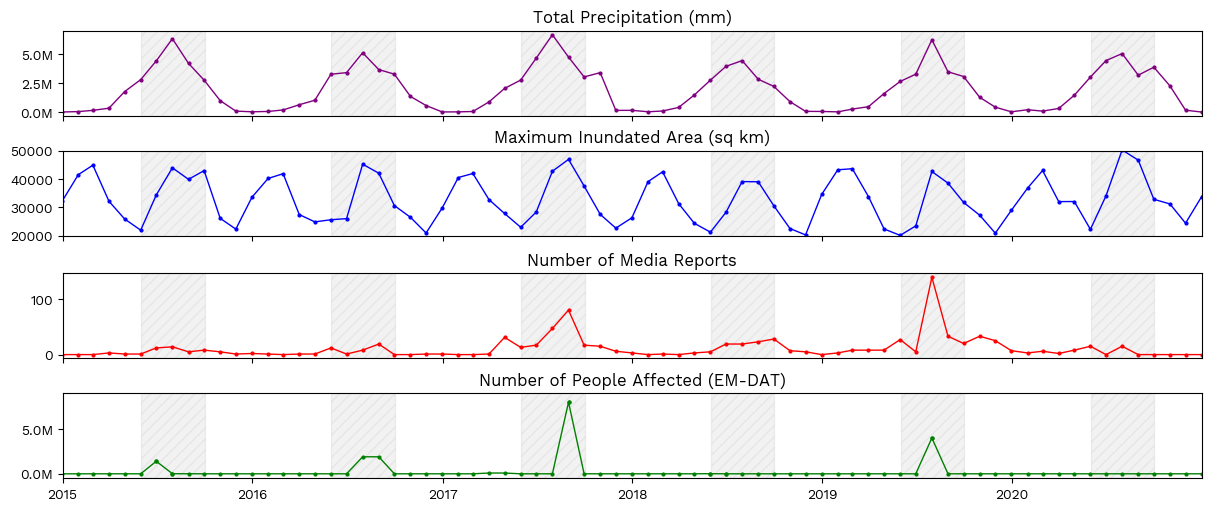

In [215]:
fig, axes = plt.subplots(4, 1, figsize=(12,5), sharex=True, constrained_layout=True)
names=['Total Precipitation (mm)', 'Maximum Inundated Area (sq km)', 'Number of Media Reports',  'Number of People Affected (EM-DAT)']

# Precip
ax=axes[0]
ax.set_title(names[0])
ax.plot(precipMonthlyTotal.time, precipMonthlyTotal.values, c= 'purple', linewidth=1, marker='o', markersize=2, label='Precipitation')
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.1f}M'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

# Inundation
ax=axes[1]
ax.set_title(names[1])
ax.plot(FIAMonthlyMaxArea.time, FIAMonthlyMaxArea.values, c= 'b', linewidth=1, marker='o',  markersize=2, label='Inundation')
ax.set_ylim(20000, 50000)

# NLP
ax=axes[2]
ax.set_title(names[2])
ax.plot(nlpMonthlyCount.time, nlpMonthlyCount.values, c= 'r', linewidth=1, marker='o',  markersize=2, label='Media reports')

# EMDAT
ax=axes[3]
ax.set_title(names[3])
ax.plot(emdatMonthly.date, emdatMonthly.people, c= 'g', linewidth=1, marker='o',  markersize=2, label='EM-DAT')
ax.set_ylim(-500000, 9000000)
ax.yaxis.set_major_formatter(ticks_y)

startPlot, endPlot = pd.to_datetime('2015-01-01'), pd.to_datetime('2020-12-31')
ax.set_xlim(startPlot, endPlot)


# Add monsoon fill
for ax in axes:
    for i, monsoon in enumerate(monsoons):
        ax.axvspan(monsoon[0], monsoon[1], alpha=0.1, color='gray', hatch='///', zorder=0, label='Monsoon')

plt.show()